In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
roi_file_paths = {
                'roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports'
                           },
                'roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/segmentations/nuclei_20240529_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports'
                           },
                'roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports'
                           },
                'timezero_roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/segmentations/segmentation_20240513_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/transcripts/20240517_segmentation_withRefid.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/exports'
                              },
                  'timezero_roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/segmentations/segment_091924_nuclei.tiff',
                            # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                            'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/transcripts/transcripts.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/exports'
                            },
                    'timezero_roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/segmentations/segment_20240921_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/transcripts/transcripts.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/exports'
                              },
                'run2_roi_2':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/',
                            },
                'run2_roi_3':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/',
                            },
                  
                  }

In [3]:
## load data for the roi of interest    
roi_of_interest = 'roi_2'

# # load the sg_object
# with open(f'{roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
#     sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [4]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [5]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    


In [6]:
### Functions to calculate gene expression statistics by groupings

# calculate the average of each gene in each group (e.g. spatial location or clone )
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64)).tolist()

    return out

# calculate the difference between maximum and minimum for each group from grouped_obs_mean
def group_delta_mean(adata, group_key, layer=None, gene_symbols=None):
    mean = grouped_obs_mean(adata, group_key, layer=layer, gene_symbols=gene_symbols)
    delta = mean.max(axis=1) - mean.min(axis=1)
    return delta

# perform permutations on the group identities and return the distribution of deltas for each gene
def permuted_group_delta_means(adata,group_key,n_perms=100, layer=None, gene_symbols=None):
    
    perms = []
    for perm in range(n_perms):
        permuted_clusters = adata.copy()
        permuted_clusters.obs[group_key] = np.random.permutation(adata.obs[group_key].values)
        gene_by_bc_cluster_mean_perm = group_delta_mean(permuted_clusters,group_key)
        perms.append(gene_by_bc_cluster_mean_perm)

    return perms

# calculate the empirical p-values for each gene
def calculate_empirical_p_values(real_values,permuted_values):
    p_values = []
    for gene in real_values.index:
        p_values.append((np.sum(permuted_values[gene] >= real_values[gene])+1)/(len(permuted_values[gene])+1))
        
    return pd.Series(p_values,index=real_values.index)

# calculate the score for each gene, which is the ratio of the real value to the mean of the permuted values
def calculate_group_scores(real_values,permuted_values):
    return real_values/np.mean(permuted_values,axis=0)



In [7]:
ring_annotated = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/ring_anotated_cell_by_gene.csv',index_col=0)
ring_annotated_100 = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/num_iterations_100/ring_anotated_cell_by_gene_100.csv',index_col=0)
ring_annotated_200 = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/num_iterations_200/ring_anotated_cell_by_gene.csv',index_col=0)

In [8]:
for ring_partition,n_partitions in zip([ring_annotated,ring_annotated_100,ring_annotated_200],[25,100,200]):


# # ring_annotated = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/cell_by_gene_with_rings.csv',index_col=0)
# ring_annotated = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/ring_anotated_cell_by_gene.csv',index_col=0)
# ring_annotated_100 = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/num_iterations_100/ring_anotated_cell_by_gene_100.csv',index_col=0)
# ring_annotated_200 = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/num_iterations_200/ring_anotated_cell_by_gene.csv',index_col=0)
# ring_annotated = ring_annotated_200

    adata_genes_ring = sc.AnnData(ring_partition[[col for col in ring_partition.columns if col in gene_cols]])

    # assign erosion ring to each cell in obs according to the ring_annoted file
    adata_genes_ring.obs['erosion_ring'] = ring_partition['Erosion_Ring'].values

        # calculate the statistics for clones
    real_delta_ring  = group_delta_mean(adata_genes_ring,'erosion_ring')
    perm_deltas_ring = permuted_group_delta_means(adata_genes_ring,'erosion_ring',n_perms=100*119)
    # perm_deltas_ring = permuted_group_delta_means(adata_genes_ring,'erosion_ring',n_perms=1000)

    # calculate the scores and p-values for the clones
    scores_ring = calculate_group_scores(real_delta_ring,pd.DataFrame(perm_deltas_ring))
    p_vals_ring = calculate_empirical_p_values(real_delta_ring,pd.DataFrame(perm_deltas_ring))


    space_score_df = pd.DataFrame({'gene':scores_ring.index,'score':scores_ring,'p_val':p_vals_ring})

    space_score_df.to_csv(f'../extractedData/space_scores_{n_partitions}rings.csv',index=False)

/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_4100/3311290446.py:10: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes_ring = sc.AnnData(ring_partition[[col for col in ring_partition.columns if col in gene_cols]])
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_4100/3311290446.py:10: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the 

In [9]:
ring_annotated_200.count('Erosion_Ring')

ValueError: No axis named Erosion_Ring for object type DataFrame

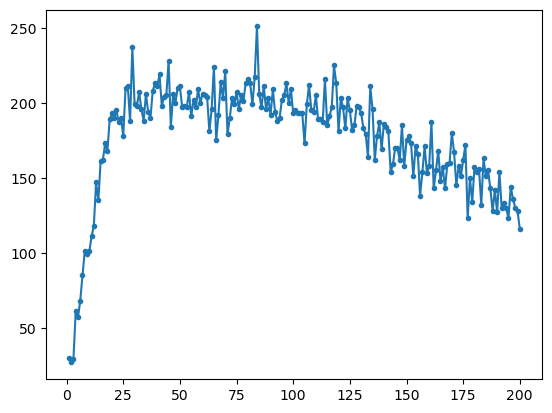

In [22]:
plt.plot(ring_annotated_200['Erosion_Ring'].value_counts().sort_index(),marker='.')

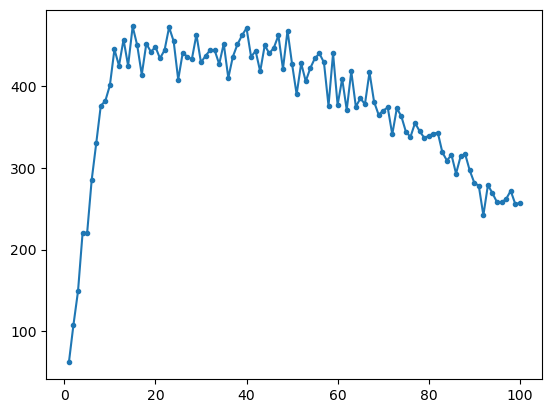

In [23]:
plt.plot(ring_annotated_100['Erosion_Ring'].value_counts().sort_index(),marker='.')

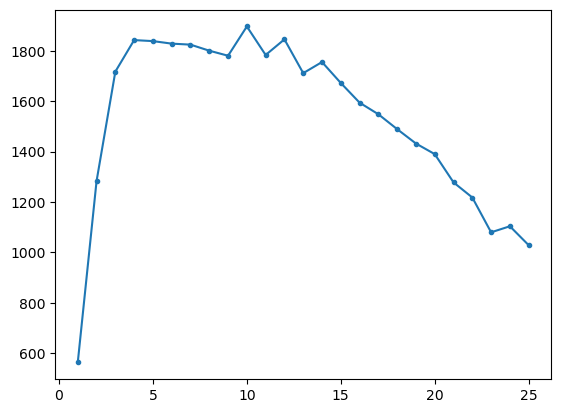

In [24]:
plt.plot(ring_annotated['Erosion_Ring'].value_counts().sort_index(),marker='.')